## Example: Refine scan positions for near-field ptychography
Data collected at I14 Nanoprobe at the Diamond Light Source

In [1]:
import h5py
import numpy as np
import scipy.ndimage as ndi
from matplotlib import pyplot as plt

### 1. Load the data

In [2]:
downsample = 4
data_path = "/home/iat69393/projects/i14-nearfield/pierre_analysis/i14_50738_prep_data_bin1.h5"
with h5py.File(data_path, "r") as f:
    data = f["data"][:]
    pos = f["positions"][:]

### 2. Pre-processing

In [3]:
# Down sample the data
data_downsampled = ndi.zoom(data, zoom=(1, 1./downsample, 1./downsample))

# Take care of negative values
data_downsampled[data_downsampled<0] = 0.

# Use median among frames to estimate flat field
flat = np.median(data_downsampled, axis=0)

# Define a mask based on thresholding the flat field
mask = (flat > .1* flat.max())

### 3. Convert motor positions

In [4]:
# Estimate pixel shifts in detector plane
xp = -pos[1]
yp = -pos[0]
px = xp * 100 / .005
py = -yp * 200 / .01
shifts0 = -np.array([py,px]).T

### 4. Initialize stitching algorithm

In [5]:
import afstitch
afs = afstitch.AlignFactorStitch(data_downsampled, shifts=shifts0, scalar=flat, mask=mask)

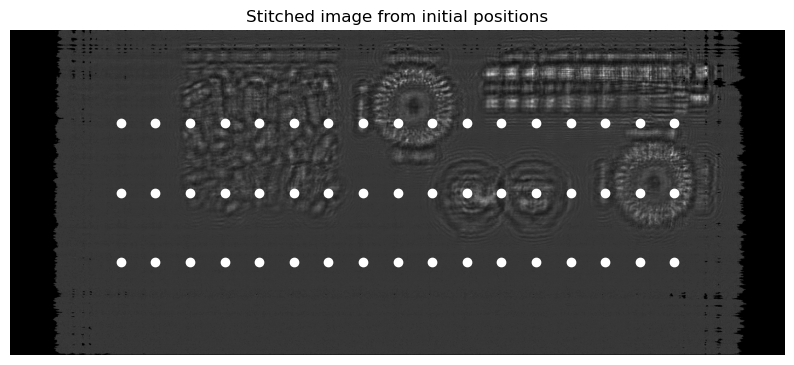

In [6]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Stitched image from initial positions")
plt.axis("off")
plt.imshow(afs.stitched, cmap="gray")
plt.plot(-shifts0[:,1]+afs.images.shape[2]//2, shifts0[:,0]+afs.images.shape[1]//2, 'wo')
plt.show()

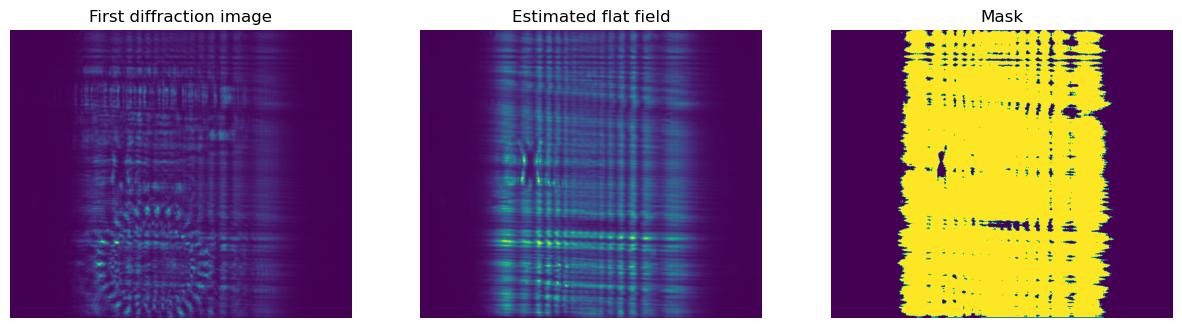

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].set_title("First diffraction image")
axes[0].axis("off")
axes[0].imshow(data_downsampled[0])
axes[1].set_title("Estimated flat field")
axes[1].axis("off")
axes[1].imshow(flat)
axes[2].set_title("Mask")
axes[2].axis("off")
axes[2].imshow(mask)
plt.show()

### 5. Run iterative solver to refine positions

In [8]:
afs.solve(refine_scalar=False, max_iter=5, max_shift=20)

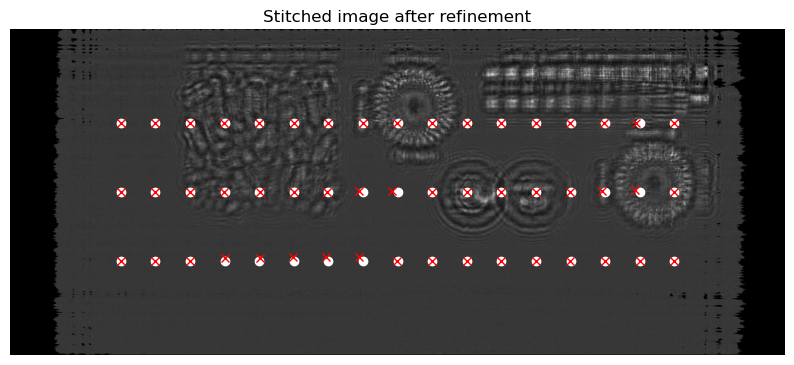

In [9]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Stitched image after refinement")
plt.axis("off")
plt.imshow(afs.stitched, cmap="gray")
plt.plot(-shifts0[:,1]+afs.images.shape[2]//2, shifts0[:,0]+afs.images.shape[1]//2, 'wo')
plt.plot(-afs.shifts[:,1]+afs.images.shape[2]//2, afs.shifts[:,0]+afs.images.shape[1]//2, 'rx')
plt.show()